## 1. Inisialisasi & Import Library
Langkah pertama adalah mengimpor semua library Python yang diperlukan untuk analisis, termasuk `pandas` untuk manipulasi data, `numpy` untuk operasi numerik, dan `scikit-learn` untuk machine learning.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 2. Memuat Dataset Awal
Memuat data dari file Excel yang berisi kritik dan saran.

In [2]:
df = pd.read_excel('kritik_saran.xlsx', sheet_name="Sheet1")

## 3. Preprocessing Teks
Tahap ini adalah inti dari persiapan data teks. Proses ini meliputi:
1.  **Mengubah tipe data** kolom ulasan menjadi string.
2.  **Stemming**: Mengubah kata ke bentuk dasarnya menggunakan library Sastrawi.
3.  **Stopword Removal**: Menghapus kata-kata umum yang tidak memiliki makna signifikan (misalnya: 'dan', 'di', 'yang').
4.  **Vektorisasi TF-IDF**: Mengubah teks menjadi representasi numerik yang dapat diolah oleh model machine learning. TF-IDF (Term Frequency-Inverse Document Frequency) memberikan bobot pada kata-kata berdasarkan frekuensinya dalam dokumen dan kelangkaannya di seluruh korpus.

In [3]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer

# Mengubah tipe data kolom 'ULASAN' menjadi string untuk menghindari error
df['ULASAN'] = df['ULASAN'].astype(str)

# Inisialisasi Stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# Inisialisasi StopWordRemover
stopword_factory = StopWordRemoverFactory()
indonesian_stopwords = stopword_factory.get_stop_words()

# Terapkan stemming pada kolom 'ULASAN'
df['ULASAN'] = df['ULASAN'].apply(lambda x: stemmer.stem(x))

# Buat TF-IDF Vectorizer dengan stopwords bahasa Indonesia
vectorizer = TfidfVectorizer(stop_words=indonesian_stopwords)
X_tfidf = vectorizer.fit_transform(df['ULASAN'])

## 4. Filterisasi Data Berdasarkan Relevansi
Untuk memastikan kualitas analisis, ulasan yang tidak relevan akan disaring. Kriteria relevansi ditentukan berdasarkan:
- **Skor TF-IDF**: Ulasan dengan skor total di atas ambang batas dianggap lebih signifikan.
- **Jumlah Kata**: Ulasan yang terlalu pendek (misalnya, kurang dari 3 kata) dianggap kurang informatif.

Data kemudian dipisahkan menjadi dua kategori: relevan dan tidak relevan.

In [4]:
# Hitung total TF-IDF score untuk setiap dokumen (ulasan)
tfidf_scores = X_tfidf.sum(axis=1)  # hasilnya matrix

# Ubah ke array 1D
df['TFIDF_Score'] = np.asarray(tfidf_scores).flatten()

# Hitung jumlah kata di setiap kalimat
df['Jumlah_Kata'] = df['ULASAN'].apply(lambda x: len(str(x).split()))

# Tandai relevan dan tidak relevan sesuai kriteria
df['Relevan'] = (df['TFIDF_Score'] > 1) & (df['Jumlah_Kata'] > 2)
df['Tidak_Relevan'] = (df['TFIDF_Score'] <= 1) & (df['Jumlah_Kata'] <= 2)

# Pisahkan data relevan dan tidak relevan
df_relevan = df[df['Relevan']]
df_tidak_relevan = df[df['Tidak_Relevan']]

# Cek hasilnya (opsional)
print(f"Jumlah data relevan: {len(df_relevan)}")
print(f"Jumlah data tidak relevan: {len(df_tidak_relevan)}")

Jumlah data relevan: 2307
Jumlah data tidak relevan: 134


## 5. Menyimpan Hasil Filterisasi
Data yang telah difilter disimpan ke dalam file Excel terpisah untuk dokumentasi dan analisis lebih lanjut.

In [5]:
df_relevan[['ULASAN', 'TFIDF_Score']].to_excel('ulasan_relevan.xlsx', index=False)
df_tidak_relevan[['ULASAN', 'TFIDF_Score']].to_excel('ulasan_tidak_relevan.xlsx', index=False)

## 6. Analisis Klastering (Topic Modeling)
Pada tahap ini, kita akan mengelompokkan ulasan yang relevan ke dalam beberapa topik atau klaster menggunakan algoritma K-Means.

### 6.1. Memuat Data Relevan
Memuat kembali data ulasan yang sudah difilter sebagai dasar untuk klastering.

In [6]:
df = pd.read_excel('ulasan_relevan.xlsx', sheet_name="Sheet1")

### 6.2. Menentukan Kombinasi Parameter Terbaik
Sebelum melakukan klastering, kita perlu mengurangi dimensi data TF-IDF menggunakan `TruncatedSVD` (mirip dengan PCA untuk data sparse). Selanjutnya, kita mencari kombinasi jumlah komponen SVD (`n_components`) dan jumlah klaster (`n_clusters`) yang optimal dengan menggunakan **Silhouette Score**. Skor ini mengukur seberapa baik sebuah objek ditempatkan dalam klasternya dibandingkan dengan klaster lain. Nilai yang lebih tinggi menunjukkan klaster yang lebih padat dan terpisah dengan baik.

n_components=50, n_clusters=2, Silhouette=0.1212
n_components=50, n_clusters=3, Silhouette=0.0854
n_components=50, n_clusters=4, Silhouette=0.0571
n_components=50, n_clusters=5, Silhouette=0.0622
n_components=50, n_clusters=6, Silhouette=0.0703
n_components=50, n_clusters=7, Silhouette=0.0793
n_components=50, n_clusters=8, Silhouette=0.0813
n_components=100, n_clusters=2, Silhouette=0.0817
n_components=100, n_clusters=3, Silhouette=0.0878
n_components=100, n_clusters=4, Silhouette=0.0498
n_components=100, n_clusters=5, Silhouette=0.0531
n_components=100, n_clusters=6, Silhouette=0.0579
n_components=100, n_clusters=7, Silhouette=0.0569
n_components=100, n_clusters=8, Silhouette=0.0545
n_components=150, n_clusters=2, Silhouette=0.0560
n_components=150, n_clusters=3, Silhouette=0.0415
n_components=150, n_clusters=4, Silhouette=0.0449
n_components=150, n_clusters=5, Silhouette=0.0424
n_components=150, n_clusters=6, Silhouette=0.0454
n_components=150, n_clusters=7, Silhouette=0.0516
n_compo

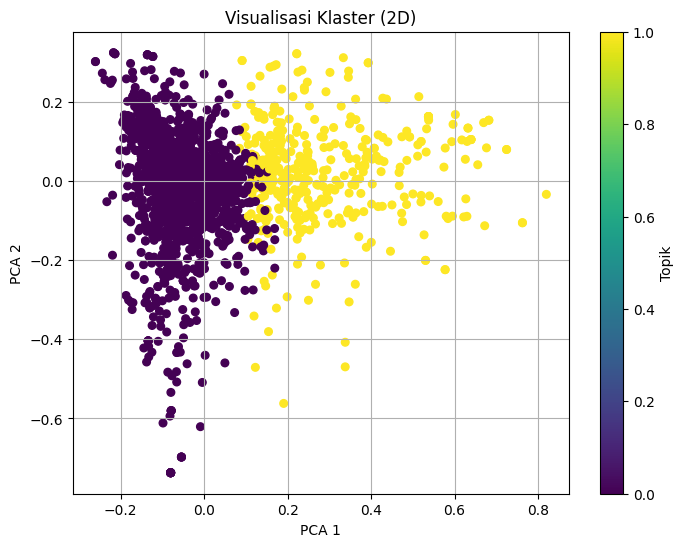

In [7]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stopwords bahasa Indonesia
factory = StopWordRemoverFactory()
stopwords_id = factory.get_stop_words()

# TF-IDF vectorizer
vectorizer_tfidf = TfidfVectorizer(stop_words=stopwords_id)
X_tfidf = vectorizer_tfidf.fit_transform(df['ULASAN'])

# CountVectorizer dan LDA
vectorizer_count = CountVectorizer(max_df=0.9, min_df=5, stop_words=stopwords_id)
X_counts = vectorizer_count.fit_transform(df['ULASAN'])
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(X_counts)

# Topik LDA ke df
topic_distribution = lda.transform(X_counts)
dominant_topic = np.argmax(topic_distribution, axis=1)
df['Topik_LDA'] = dominant_topic

# Cari kombinasi terbaik n_components dan n_clusters
n_components_list = [50, 100, 150, 200, 250]
n_clusters_list = range(2, 9)

best_score = -1
best_config = (None, None)

for n_components in n_components_list:
    svd = TruncatedSVD(n_components=n_components, random_state=0)
    X_reduced = svd.fit_transform(X_tfidf)
    
    for k in n_clusters_list:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(X_reduced)
        score = silhouette_score(X_reduced, labels)
        print(f"n_components={n_components}, n_clusters={k}, Silhouette={score:.4f}")
        
        if score > best_score:
            best_score = score
            best_config = (n_components, k)

print(f"\nBest combo: n_components={best_config[0]}, n_clusters={best_config[1]} with Silhouette={best_score:.4f}")

# Buat model dengan parameter terbaik
best_n_components, best_n_clusters = best_config
svd = TruncatedSVD(n_components=best_n_components, random_state=0)
X_reduced = svd.fit_transform(X_tfidf)

kmeans = KMeans(n_clusters=best_n_clusters, random_state=0)
df['Topik'] = kmeans.fit_predict(X_reduced)

# Fungsi top tfidf kata per cluster
def top_tfidf_words(docs, top_n=10):
    vec = TfidfVectorizer(stop_words=stopwords_id)
    X = vec.fit_transform(docs)
    mean_tfidf = np.asarray(X.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    return [vec.get_feature_names_out()[i] for i in top_indices]

for i in range(best_n_clusters):
    cluster_docs = df[df['Topik'] == i]['ULASAN']
    print(f"\nTop kata di Klaster {i}: {top_tfidf_words(cluster_docs)}")

# Visualisasi hasil klaster 2D
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X_reduced)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['Topik'], cmap='viridis', s=30)
plt.title("Visualisasi Klaster (2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Topik')
plt.grid(True)
plt.show()

## 7. Interpretasi dan Pelabelan Klaster
Setelah klaster terbentuk, langkah selanjutnya adalah menginterpretasi makna dari setiap klaster. Ini dilakukan dengan melihat kata-kata yang paling representatif dari setiap klaster. Berdasarkan interpretasi tersebut, setiap klaster diberi label yang sesuai (misalnya, 'Kritik & Harapan', 'Saran & Pujian'). Hasilnya kemudian disimpan dalam file Excel baru.

In [8]:
# 1. Buat label yang bermakna untuk tiap topik
topic_labels = {
    0: "Kritik Dan Harapan",
    1: "Saran dan Pujian"
}

# 2. Map ke DataFrame
df['Topik_Label'] = df['Topik'].map(topic_labels)

# 3. Tampilkan hasil lengkap

pd.set_option('display.max_colwidth', None)
print(df[['ULASAN', 'Topik', 'Topik_Label']])
# Lihat contoh ulasan dari tiap topik
print(df[df['Topik'] == 0]['ULASAN'].sample(5))
print(df[df['Topik'] == 1]['ULASAN'].sample(5))


df[['ULASAN', 'Topik', 'Topik_Label']].to_excel("hasil_klaster_teks_asli.xlsx", index=False)

                                                                                                                           ULASAN  \
0                                                                                                             acnya kurang dingin   
1                                                                                moga latih di luas lagi lingkup di kota parepare   
2                                                                                              lumayan dinginn dan lumayan bersih   
3                                                                                                             cahaya ruang kurang   
4                                                        untuk anak jgd kursi nya kecil susah mouse gerak lebih bagus terimakasih   
...                                                                                                                           ...   
2302                                                                 

## 8. Pelatihan Model Klasifikasi (Naive Bayes)
Setelah data memiliki label topik (hasil dari klastering), kita dapat menggunakan data ini untuk melatih model klasifikasi. Model ini nantinya dapat memprediksi topik dari ulasan baru secara otomatis.

Prosesnya adalah sebagai berikut:
1.  **Pembagian Data**: Data dibagi menjadi set pelatihan (80%) dan set pengujian (20%).
2.  **Vektorisasi TF-IDF**: Teks kembali diubah menjadi vektor numerik.
3.  **Pelatihan Model**: Model `Multinomial Naive Bayes` dilatih menggunakan data pelatihan. Algoritma ini sangat cocok untuk klasifikasi teks.

In [9]:
df['ULASAN'] = df['ULASAN'].fillna('').astype(str)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Fitur dan label
X = df['ULASAN']
y = df['Topik_Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF
vectorizer = TfidfVectorizer(stop_words=stopwords_id)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Prediksi
y_pred = nb.predict(X_test_tfidf)

## 9. Evaluasi Model
Performa model dievaluasi menggunakan data pengujian. Metrik yang digunakan adalah:
- **Classification Report**: Menampilkan `precision`, `recall`, dan `f1-score` untuk setiap kelas. Ini memberikan gambaran lengkap tentang seberapa baik model mengklasifikasikan setiap topik.
- **Confusion Matrix**: Menunjukkan jumlah prediksi yang benar dan salah untuk setiap kelas. Ini membantu untuk melihat di mana model sering membuat kesalahan.

In [10]:
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report:
                    precision    recall  f1-score   support

Kritik Dan Harapan       0.90      0.99      0.95       385
  Saran dan Pujian       0.95      0.47      0.63        77

          accuracy                           0.91       462
         macro avg       0.93      0.73      0.79       462
      weighted avg       0.91      0.91      0.89       462


🧮 Confusion Matrix:
[[383   2]
 [ 41  36]]


## 10. Uji Coba Model pada Data Baru
Menggunakan model yang telah dilatih untuk memprediksi topik dari beberapa contoh kalimat baru. Ini menunjukkan bagaimana model akan bekerja dalam aplikasi nyata.

In [11]:
new_texts = ["materi sangat mudah dipahami", "kursi keras dan ruang terlalu panas"]
new_vec = vectorizer.transform(new_texts)
predictions = nb.predict(new_vec)

for txt, label in zip(new_texts, predictions):
    print(f"\n📝 \"{txt}\" → 🔖 Predicted Topik: {label}")


📝 "materi sangat mudah dipahami" → 🔖 Predicted Topik: Saran dan Pujian

📝 "kursi keras dan ruang terlalu panas" → 🔖 Predicted Topik: Kritik Dan Harapan


## 11. Menyimpan Model dan Vectorizer
Langkah terakhir adalah menyimpan model Naive Bayes dan TF-IDF Vectorizer yang telah dilatih ke dalam file menggunakan `joblib`. Ini memungkinkan kita untuk memuat kembali model dan vectorizer di lain waktu tanpa harus melatih ulang dari awal.

In [12]:
import joblib

# Simpan model Naive Bayes
joblib.dump(nb, 'Model_Naive_bayes.pkl')

# Simpan vectorizer TF-IDF
joblib.dump(vectorizer, 'Model_TF-IDF.pkl')

['Model_TF-IDF.pkl']